[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hamidrg/Textual_Emotion_detect/blob/master/Transformers/RoBERTa.ipynb)

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import spacy
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import kagglehub

path = kagglehub.dataset_download("akhilvibhakar/isear-raw")
df = pd.read_csv(path + "/ISEAR-raw-utf8.csv")

df.head()

100%|██████████| 507k/507k [00:00<00:00, 66.9MB/s]

Extracting files...


,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,...,SELF,RELA,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE
0,11001,1,1,1,1,33,1,2,6,1,...,3,3,2,0,joy,4,3,110011,"During the period of falling in love, each tim...",1
1,11001,1,1,1,1,33,1,2,6,1,...,2,2,0,0,fear,3,2,110012,When I was involved in a traffic accident.,1
2,11001,1,1,1,1,33,1,2,6,1,...,2,1,0,0,anger,1,3,110013,When I was driving home after several days of...,1
3,11001,1,1,1,1,33,1,2,6,1,...,1,1,0,2,sadness,4,4,110014,When I lost the person who meant the most to me.,1
4,11001,1,1,1,1,33,1,2,6,1,...,0,2,0,0,disgust,4,4,110015,The time I knocked a deer down - the sight of ...,1


In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num]
    return " ".join(tokens)


df['sentence'] = df['SIT'].apply(preprocess_text)

# Label encoding
label_names = sorted(df['Field1'].unique())
label2id = {label: idx for idx, label in enumerate(label_names)}
id2label = {idx: label for label, idx in label2id.items()}
df['label_id'] = df['Field1'].map(label2id)

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['sentence'].tolist(), df['label_id'].tolist(), test_size=0.1, random_state=42, stratify=df['label_id']
)

In [ ]:
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id
).to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
patience = 2
best_test_loss = float('inf')
epochs_no_improve = 0
early_stop = False
num_epochs = 10

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    if early_stop:
        print("⛔ Early stopping activated.")
        break

    # ====== Training ======
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ====== Test Evaluation ======
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            test_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # ====== Logging ======
    print("=" * 50)
    print(f" 🏁 Epoch {epoch+1} Summary")
    print("-" * 50)
    print(f" 🧠 Train Loss : {train_loss:.4f} | ✅ Train Acc : {train_acc:.4f}")
    print(f" 🔬 Test Loss  : {test_loss:.4f} | 📈 Test Acc  : {test_acc:.4f}")
    print("=" * 50 + "\n")

    # ====== Early Stopping Logic ======
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
        # torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

Epoch 1/10 - Testing: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


 🏁 Epoch 1 Summary
--------------------------------------------------
 🧠 Train Loss : 1.3266 | ✅ Train Acc : 0.5236
 🔬 Test Loss  : 1.1260 | 📈 Test Acc  : 0.5997



Epoch 2/10 - Testing: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


 🏁 Epoch 2 Summary
--------------------------------------------------
 🧠 Train Loss : 1.0339 | ✅ Train Acc : 0.6224
 🔬 Test Loss  : 1.1021 | 📈 Test Acc  : 0.6141



Epoch 3/10 - Testing: 100%|██████████| 12/12 [00:02<00:00,  4.84it/s]


 🏁 Epoch 3 Summary
--------------------------------------------------
 🧠 Train Loss : 0.8680 | ✅ Train Acc : 0.6858
 🔬 Test Loss  : 1.1526 | 📈 Test Acc  : 0.5893



Epoch 4/10 - Testing: 100%|██████████| 12/12 [00:02<00:00,  4.82it/s]

 🏁 Epoch 4 Summary
--------------------------------------------------
 🧠 Train Loss : 0.7115 | ✅ Train Acc : 0.7429
 🔬 Test Loss  : 1.1942 | 📈 Test Acc  : 0.6167

⛔ Early stopping activated.


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/roberta_emotion.pth")
print("✅ Model saved to Drive.")

# To load:
# model.load_state_dict(torch.load("/content/drive/MyDrive/roberta_emotion.pth"))
# model.eval()

✅ Model saved to Drive.


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_names))


Classification Report:

              precision    recall  f1-score   support

       anger       0.43      0.50      0.46       110
     disgust       0.69      0.67      0.68       110
        fear       0.84      0.76      0.80       109
       guilt       0.64      0.43      0.51       109
         joy       0.76      0.74      0.75       109
     sadness       0.72      0.60      0.65       110
       shame       0.42      0.61      0.50       110

    accuracy                           0.62       767
   macro avg       0.64      0.62      0.62       767
weighted avg       0.64      0.62      0.62       767



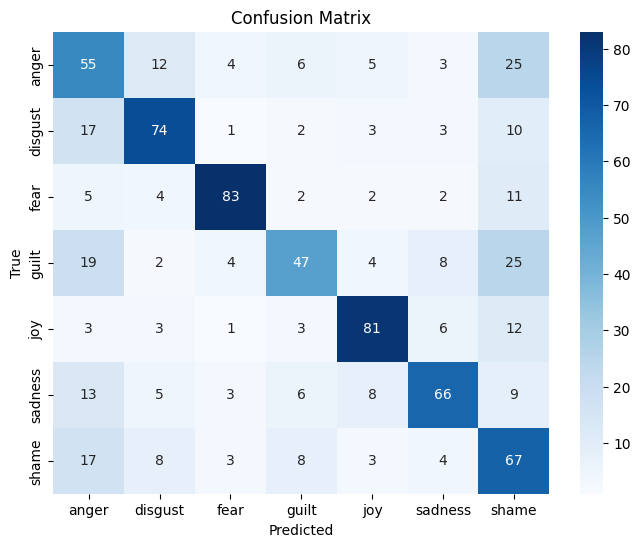

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

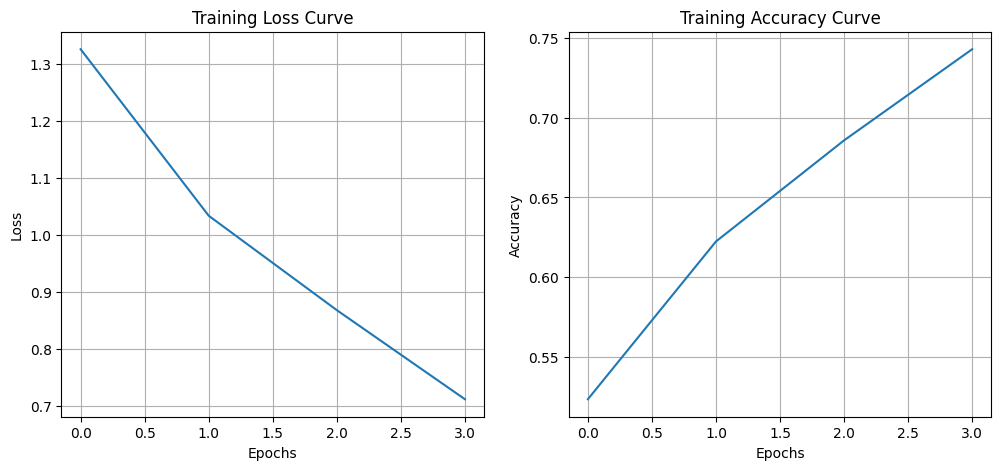

In [ ]:
# Plot Loss and Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.title("Training Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [ ]:
# Set model to evaluation mode
model.eval()

# Get label mapping from the model
id2label = model.config.id2label

# Number of examples to test
n_samples = 5
count = 0

print("🔍 Testing model on sample inputs:\n" + "=" * 50)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        for i in range(len(input_ids)):
            if count >= n_samples:
                break

            # Decode input tokens to original text
            text = tokenizer.decode(input_ids[i], skip_special_tokens=True)

            true_label = id2label[labels[i].item()]
            pred_label = id2label[preds[i].item()]

            print(f"📝 Text       : {text}")
            print(f"✅ True Label : {true_label}")
            print(f"🔮 Predicted  : {pred_label}")
            print("-" * 50)

            count += 1

        if count >= n_samples:
            break

🔍 Testing model on sample inputs:
📝 Text       : response
✅ True Label : shame
🔮 Predicted  : shame
--------------------------------------------------
📝 Text       : close friend family die
✅ True Label : sadness
🔮 Predicted  : sadness
--------------------------------------------------
📝 Text       : mother develop hipertonia think blame á 
 bacause stress disease
✅ True Label : guilt
🔮 Predicted  : sadness
--------------------------------------------------
📝 Text       : have good trip boat good friend
✅ True Label : joy
🔮 Predicted  : joy
--------------------------------------------------
📝 Text       : accident happen little cousin take á 
 care fall floor hand á 
 hurt
✅ True Label : guilt
🔮 Predicted  : guilt
--------------------------------------------------
